# Treetime Analysis

## Setup

---

### Module Imports

In [1]:
from Bio import Phylo
from treetime.utils import parse_dates
from treetime import wrappers

import copy
import os

import pandas
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors, lines, patches

### Input File Paths

In [2]:
'''
tree_path = str(snakemake.input.tree)
aln_path = str(snakemake.input.snp_aln)
metadata_path = str(snakemake.input.metadata)
treetime_path = str(snakemake.output.treetime)
'''
tree_path = "../../docs/results/2020-11-09/iqtree/iqtree-core_chromosome.filter5.treefile"
metadata_path = "../../docs/results/2020-12-08/metadata/metadata.txt"

### Constants and Variables

In [3]:
NAME_COL = "Sample"
DATES_COL = "Date"
ATTRIBUTE = "Biovar"
MUG_CONF_THRESH = 0.95
NO_DATA_CHAR = "NA"
COLOR_PAL = "rainbow"

### Convert Newick Tree to Temp XML

In [4]:
tmp_xml = os.path.join(os.path.dirname(tree_path), "temp.xml")
Phylo.convert(tree_path, "newick", tmp_xml, "phyloxml")

1

### Rename Internal Nodes and Parse Confidence

In [5]:
tree_div = Phylo.read(tmp_xml, "phyloxml")
# Deepest nodes first
tree_div.ladderize(reverse=True)

node_i = 0

for c in tree_div.find_clades():
    if not c.name:
        continue
    
    # Assuming IQTREE was run to have format aLRT/UFBoot.
    name_split = c.name.split("/")
    
    # If it's a terminal node
    if c.is_terminal():
        c.color = "grey"
    
    # Check if the name has 'accidentally' become the confidence vals
    if (
        len(name_split) == 2 
        and float(name_split[0]) >= 0 and float(name_split[1]) <= 100
        and float(name_split[1]) >= 0 and float(name_split[1])  <= 100
        ):

        # Name the internal node
        c.name = "NODE" + str(node_i)
        
        # Assign confidence values
        alrt_val = float(name_split[0])
        alrt_conf = Phylo.PhyloXML.Confidence(alrt_val, type="alrt")
        
        ufboot_val = float(name_split[1])
        ufboot_conf = Phylo.PhyloXML.Confidence(ufboot_val, type="ufboot")
        
        c.confidences.append(alrt_conf)
        c.confidences.append(ufboot_conf)
        
        c.color = "black"       
        # Strong branch support: alrt >= 80, UFboot >= 95
        if alrt_val >= 80 and ufboot_val >= 95:
            c.color = "red"
        
        # Increment node counter
        node_i += 1

### Draw the Tree Colored By Confidence

1

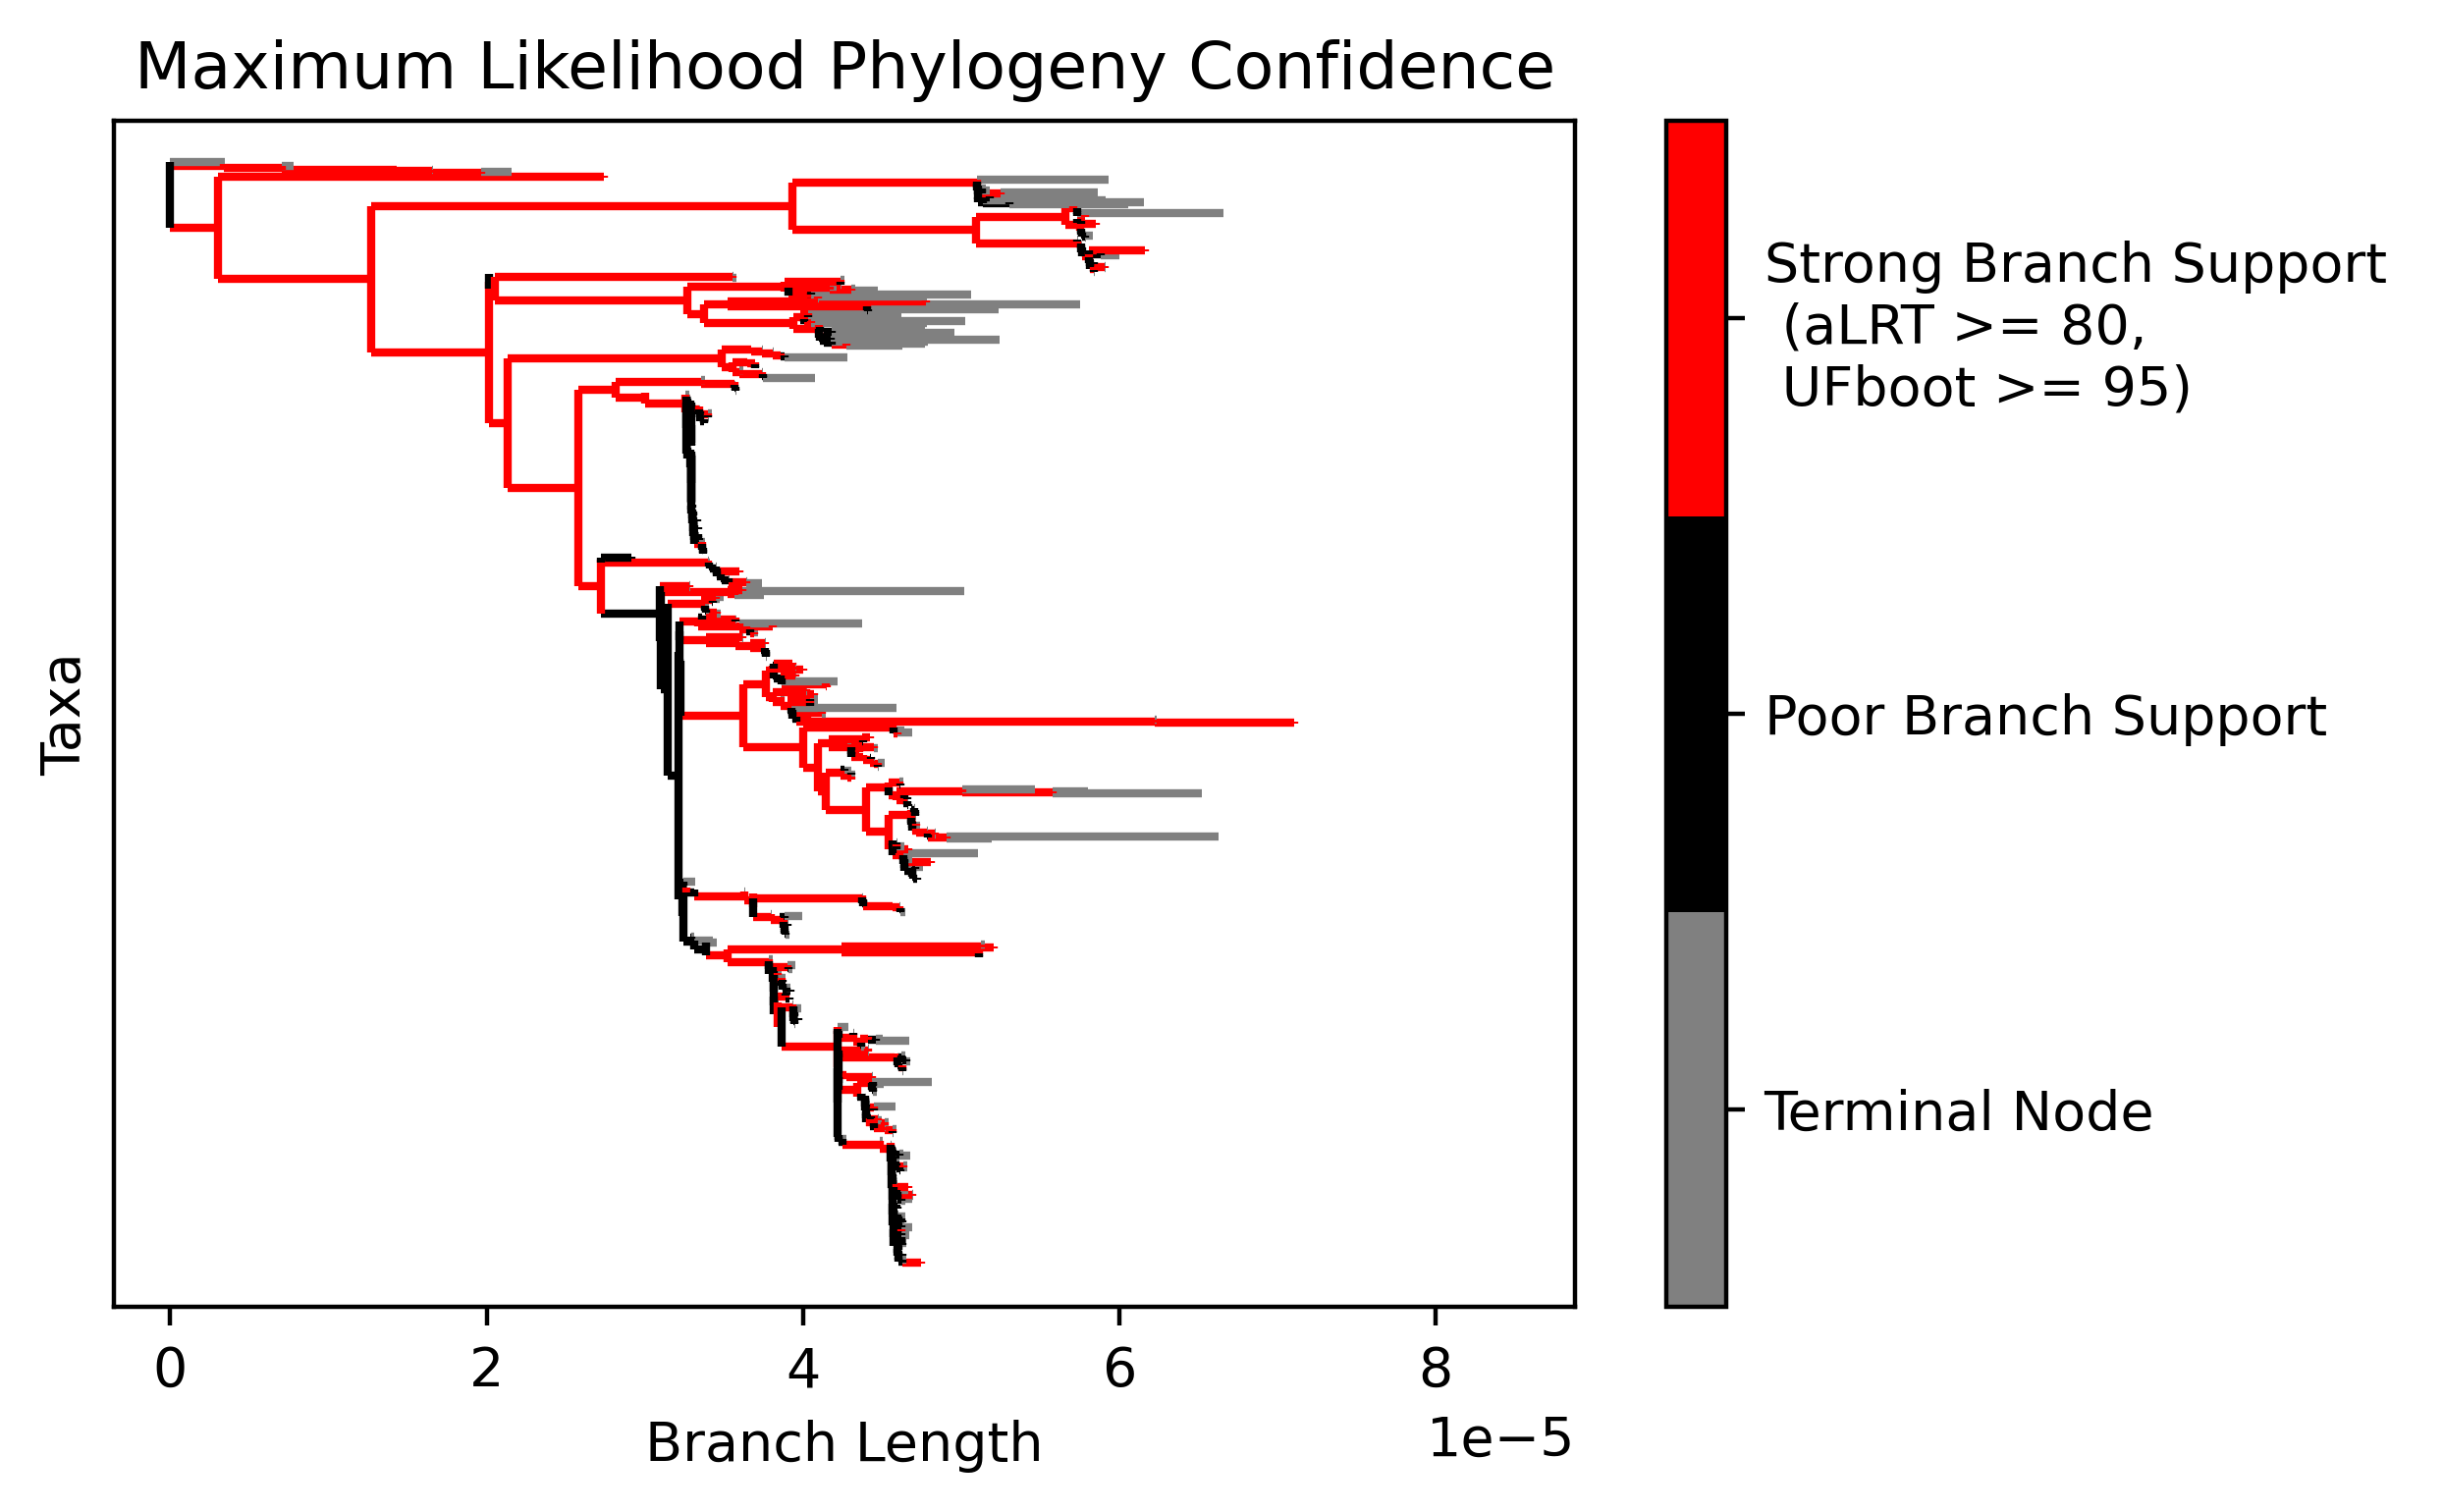

In [6]:
plt.figure(dpi=400)
ax = plt.subplot()

Phylo.draw(tree_div,
           axes=ax,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# Root branch length set to 0.001
#ax.set_xlim(0.000999,0.00108)
ax.set_ylim(-20,len(tree_div.get_terminals())+20)
ax.set_yticks([])

cmap = colors.ListedColormap(["grey","black","red"], name='conf_cmap', N=None)
norm = colors.Normalize(vmin=0.5,vmax=3.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(1,3,3))
cbar.ax.set_yticklabels(["Terminal Node",
                         "Poor Branch Support",
                         "Strong Branch Support \n (aLRT >= 80, \n UFboot >= 95)",]) 

plt.xlabel("Branch Length")
plt.ylabel("Taxa")
plt.title("Maximum Likelihood Phylogeny Confidence")
plt.savefig("treetime_confidence_tree.png", dpi=400, bbox_inches = "tight")

# Write Tree File
Phylo.write(tree_div, 
            "treetime_confidence_tree.xml",
            "phyloxml")

In [7]:
# Sanity check
#for c in tree_div.find_clades():
#    print(c, c.name, c.branch_length, c.confidences)

### Parse Dates

In [8]:
# Parse the metadata
states = pandas.read_csv(metadata_path, sep='\t')

# Tell treetime which column is the taxon name
if NAME_COL in states.columns:
    taxon_name = NAME_COL

# Tell treetime which column is the attribute for mugration
if ATTRIBUTE in states.columns:
    attr = ATTRIBUTE

# Get tips names
tree_tip_names = [t.name for t in tree_div.get_terminals()]

## Analysis

### Mugration Estimation

In [9]:
# Map the taxon name to the mugration attribute
leaf_to_attr = {x[taxon_name]:str(x[attr]) for xi, x in states.iterrows()
                    if x[attr]!=NO_DATA_CHAR and x[attr]}
#print(leaf_to_attr)

# Optional: simplify the Mictorus biovar
for leaf in leaf_to_attr:
    leaf_attr = leaf_to_attr[leaf]
    if leaf_attr in ["Ulegeica", "Altaica", "Talassica", "Hissarica", "Xilingolensis", "Caucasica"]:
        leaf_to_attr[leaf] = "Microtus"

In [10]:
# Run the mugration (default nan comes from previous step)
mug, letter_to_state, reverse_alphabet = wrappers.reconstruct_discrete_traits(tree=tree_div, 
                                                                     traits=leaf_to_attr, 
                                                                     missing_data="nan",
                                                                     #pc=pc, 
                                                                     #sampling_bias_correction=sampling_bias_correction, 
                                                                     verbose=4, 
                                                                     #weights=params.weights
                                                                    )



0.00	-TreeAnc: set-up
Assigned discrete traits to 327 out of 540 taxa.


0.18	-SequenceData: loaded alignment.

0.18	-SeqData: making compressed alignment...

0.18	-SequenceData: constructed compressed alignment...

0.20	-TreeAnc.infer_ancestral_sequences with method: ml, marginal
0.20	--TreeAnc._ml_anc_marginal: type of reconstruction: Marginal
0.20	---Attaching sequence profiles to leafs...
0.21	---Postorder: computing likelihoods...
0.26	---Computing root node sequence and total tree likelihood...
0.26	---Preorder: computing marginal profiles...
0.33	---TreeAnc._ml_anc_marginal: ...done
0.44	--TreeAnc.infer_gtr: counting mutations...
0.52	---TreeAnc.infer_gtr: counting mutations...done

0.52	-GTR: with alphabet: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
0.52	--GTR: ambiguous character: I
0.52	----GTR: no gap symbol!
0.52	---GTR: init with dummy values!

0.52	-GTR: model inference
0.52	---GTR inference iteration 0 change: 0.3535533905932738
0.52	---GTR inference iteration 1 change: 0

2.91	---Computing root node sequence and total tree likelihood...
2.92	---Attaching sequence profiles to leafs...
2.92	---Postorder: computing likelihoods...
2.97	---Computing root node sequence and total tree likelihood...
2.97	---Attaching sequence profiles to leafs...
2.98	---Postorder: computing likelihoods...
3.02	---Computing root node sequence and total tree likelihood...
3.02	---Attaching sequence profiles to leafs...
3.03	---Postorder: computing likelihoods...
3.07	---Computing root node sequence and total tree likelihood...
3.07	---Attaching sequence profiles to leafs...
3.08	---Postorder: computing likelihoods...
3.13	---Computing root node sequence and total tree likelihood...
3.13	---Attaching sequence profiles to leafs...
3.13	---Postorder: computing likelihoods...
3.18	---Computing root node sequence and total tree likelihood...
3.18	---Attaching sequence profiles to leafs...
3.18	---Postorder: computing likelihoods...
3.23	---Computing root node sequence and total tree 

5.58	---Computing root node sequence and total tree likelihood...
5.58	---Attaching sequence profiles to leafs...
5.59	---Postorder: computing likelihoods...
5.64	---Computing root node sequence and total tree likelihood...
5.64	---Attaching sequence profiles to leafs...
5.64	---Postorder: computing likelihoods...
5.69	---Computing root node sequence and total tree likelihood...
5.69	---Attaching sequence profiles to leafs...
5.70	---Postorder: computing likelihoods...
5.75	---Computing root node sequence and total tree likelihood...
5.75	---Attaching sequence profiles to leafs...
5.75	---Postorder: computing likelihoods...
5.80	---Computing root node sequence and total tree likelihood...
5.80	---Attaching sequence profiles to leafs...
5.80	---Postorder: computing likelihoods...
5.86	---Computing root node sequence and total tree likelihood...
5.86	---Attaching sequence profiles to leafs...
5.87	---Postorder: computing likelihoods...
5.92	---Computing root node sequence and total tree 

In [11]:
# All unique states from mugration
unique_states = sorted(letter_to_state.values())
#print(unique_states)
#print(len(unique_states))

### Add Node Properties

ALL:  1078
LOW CONFIDENCE:  300 27.82931354359926
HIGH CONFIDENCE:  778 72.17068645640074


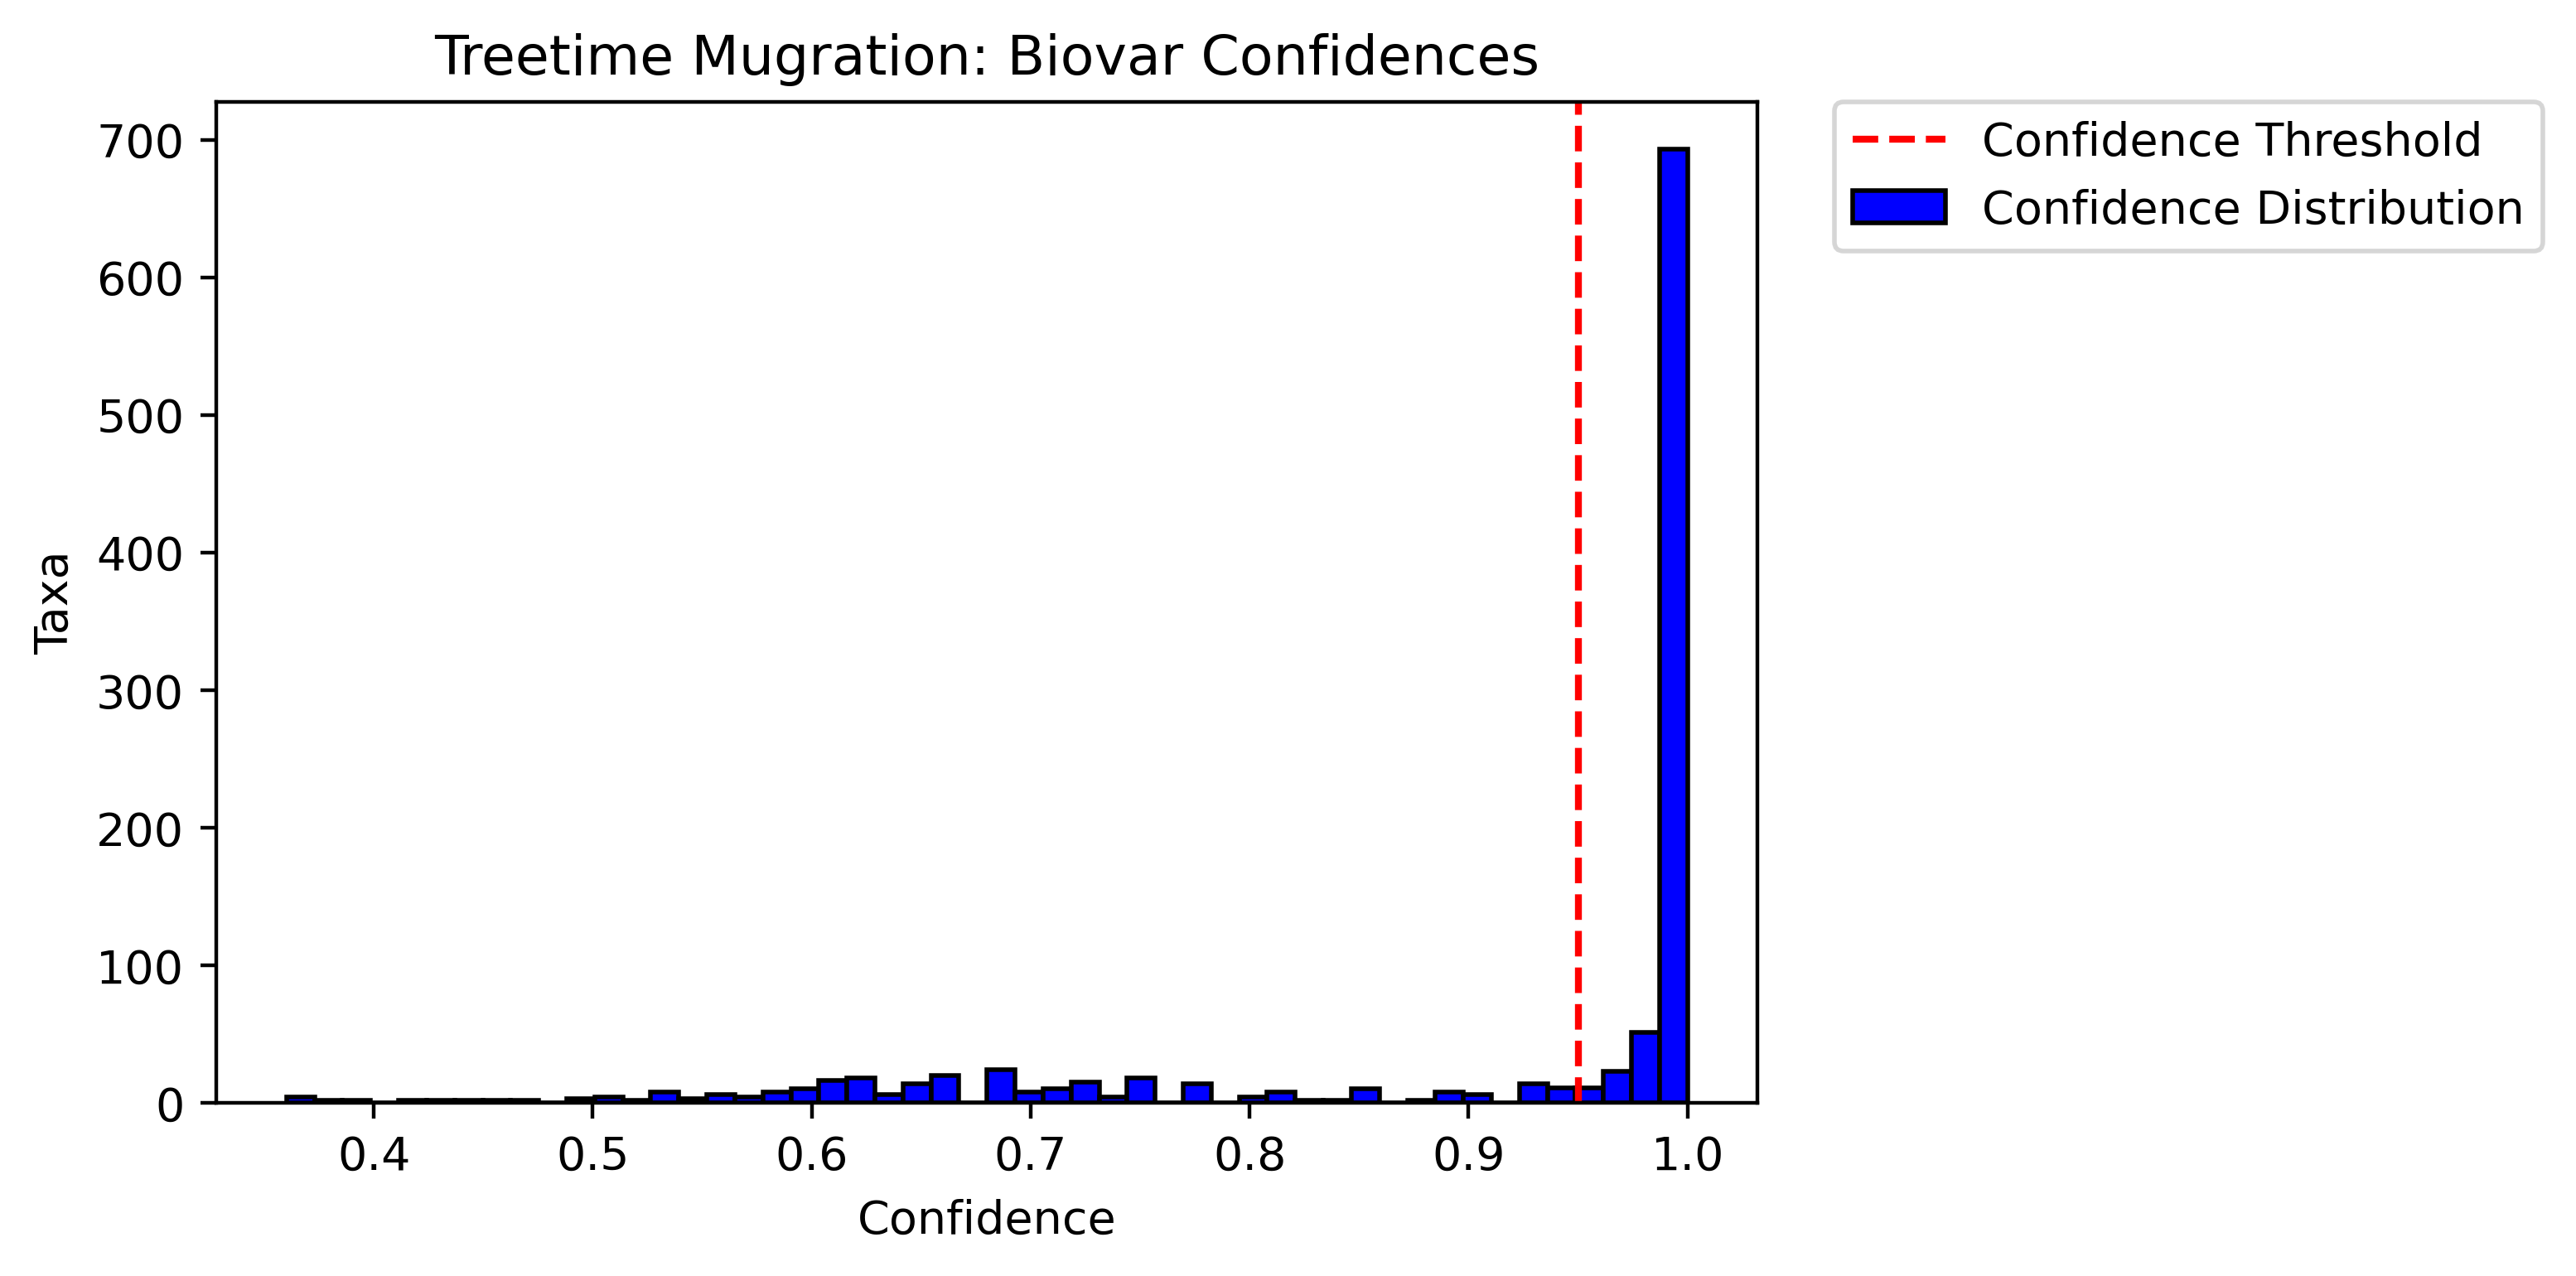

In [12]:
attr_conf_list = []
attr_high_conf = []
attr_low_conf = []

for c in mug.tree.find_clades():
    mug_attr = letter_to_state[c.cseq[0]]
    mug_conf = c.marginal_profile[0]
    attr_conf = max(c.marginal_profile[0])
    attr_conf_list.append(attr_conf)
    
    if attr_conf < MUG_CONF_THRESH:
        attr_low_conf.append(attr_conf)
        attr_other = Phylo.PhyloXML.Other(tag=ATTRIBUTE, value="Low Confidence", namespace="mugration")
    elif attr_conf >= MUG_CONF_THRESH:
        attr_high_conf.append(attr_conf)
        attr_other = Phylo.PhyloXML.Other(tag=ATTRIBUTE, value=mug_attr, namespace="mugration")
    c.other.append(attr_other)

print("ALL: ", len(attr_conf_list))
print("LOW CONFIDENCE: ", len(attr_low_conf), len(attr_low_conf)/len(attr_conf_list) * 100)
print("HIGH CONFIDENCE: ", len(attr_high_conf), len(attr_high_conf)/len(attr_conf_list) * 100)

fig = plt.figure(dpi=400)
ax = plt.subplot()

plt.hist(attr_conf_list, color = 'blue', edgecolor = 'black', bins=50, label="Confidence Distribution")
plt.axvline(x=MUG_CONF_THRESH, color="red", linestyle='--', label="Confidence Threshold")
plt.xlabel('Confidence')
plt.ylabel('Taxa')


#blue_patch = patches.Patch(color='blue', label='Confidence Distribution')
#red_line = lines.Line(color='red', label='Confidence Threshold')
#plt.legend(handles=[blue_patch])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title("Treetime Mugration: {} Confidences".format(ATTRIBUTE))
plt.savefig("treetime_biovar_confidence_hist.png", dpi=400, bbox_inches = "tight")

### Draw Mugration Tree

In [13]:
# Make a copy of the tree to edit values
mug_tree_div = copy.deepcopy(mug.tree)
# Deepest nodes first
mug_tree_div.ladderize(reverse=False)

# Initialize the states with the low confidence 
ordered_states = ["Low Confidence"]

# Get the ladderized order of attributes
for t in mug_tree_div.get_terminals():
    print(t)
    print(t.other)
    for prop in t.other:
        if prop.tag == "Biovar" and prop.value not in ordered_states:
            print(prop.value)
            ordered_states.append(prop.value)

# Number of states that need colors (exclude nan)
num_attr = len(unique_states[:-1])

# Create the custom color map
cmap = plt.get_cmap(COLOR_PAL,num_attr)
# Convert to a list of colors
cmaplist = [cmap(i) for i in range(cmap.N)]

# force the first color entry to be grey
cmaplist = [(.5, .5, .5, 1.0)] + cmaplist 
num_attr = num_attr + 1

# create the new map
cmap = colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, num_attr)

cmaplist = cmap(np.linspace(0, 1, num_attr))
hex_list = [colors.to_hex(col) for col in cmaplist]

hex_dict = {}

print(ordered_states)
print(hex_list)

# Assign states colors based on tip order (Low Conf first as grey)
for state,hex_col in zip(ordered_states, hex_list):
    print(state,hex_col)
    hex_dict[state] = hex_col

# Deepest nodes last
mug_tree_div.ladderize(reverse=True)

# Color branches by attr
for c in mug_tree_div.find_clades():
    for prop in c.other:
        if prop.tag == ATTRIBUTE:
            c.color = hex_dict[prop.value]

SAMEA3541827
[Other(namespace='mugration', tag='Biovar', value='Bronze Age Plague')]
Bronze Age Plague
SAMEA104233046
[Other(namespace='mugration', tag='Biovar', value='Bronze Age Plague')]
SAMEA104233050
[Other(namespace='mugration', tag='Biovar', value='Bronze Age Plague')]
SAMEA104233047
[Other(namespace='mugration', tag='Biovar', value='Bronze Age Plague')]
SAMEA104233049
[Other(namespace='mugration', tag='Biovar', value='Bronze Age Plague')]
SAMEA104233048
[Other(namespace='mugration', tag='Biovar', value='Bronze Age Plague')]
SAMEA3541826
[Other(namespace='mugration', tag='Biovar', value='Bronze Age Plague')]
GCA_000323485.1_ASM32348v1_genomic
[Other(namespace='mugration', tag='Biovar', value='Antiqua')]
Antiqua
GCA_000323845.1_ASM32384v1_genomic
[Other(namespace='mugration', tag='Biovar', value='Antiqua')]
GCA_001601675.1_ASM160167v1_genomic
[Other(namespace='mugration', tag='Biovar', value='Microtus')]
Microtus
GCA_002127375.1_ASM212737v1_genomic
[Other(namespace='mugration', t

1

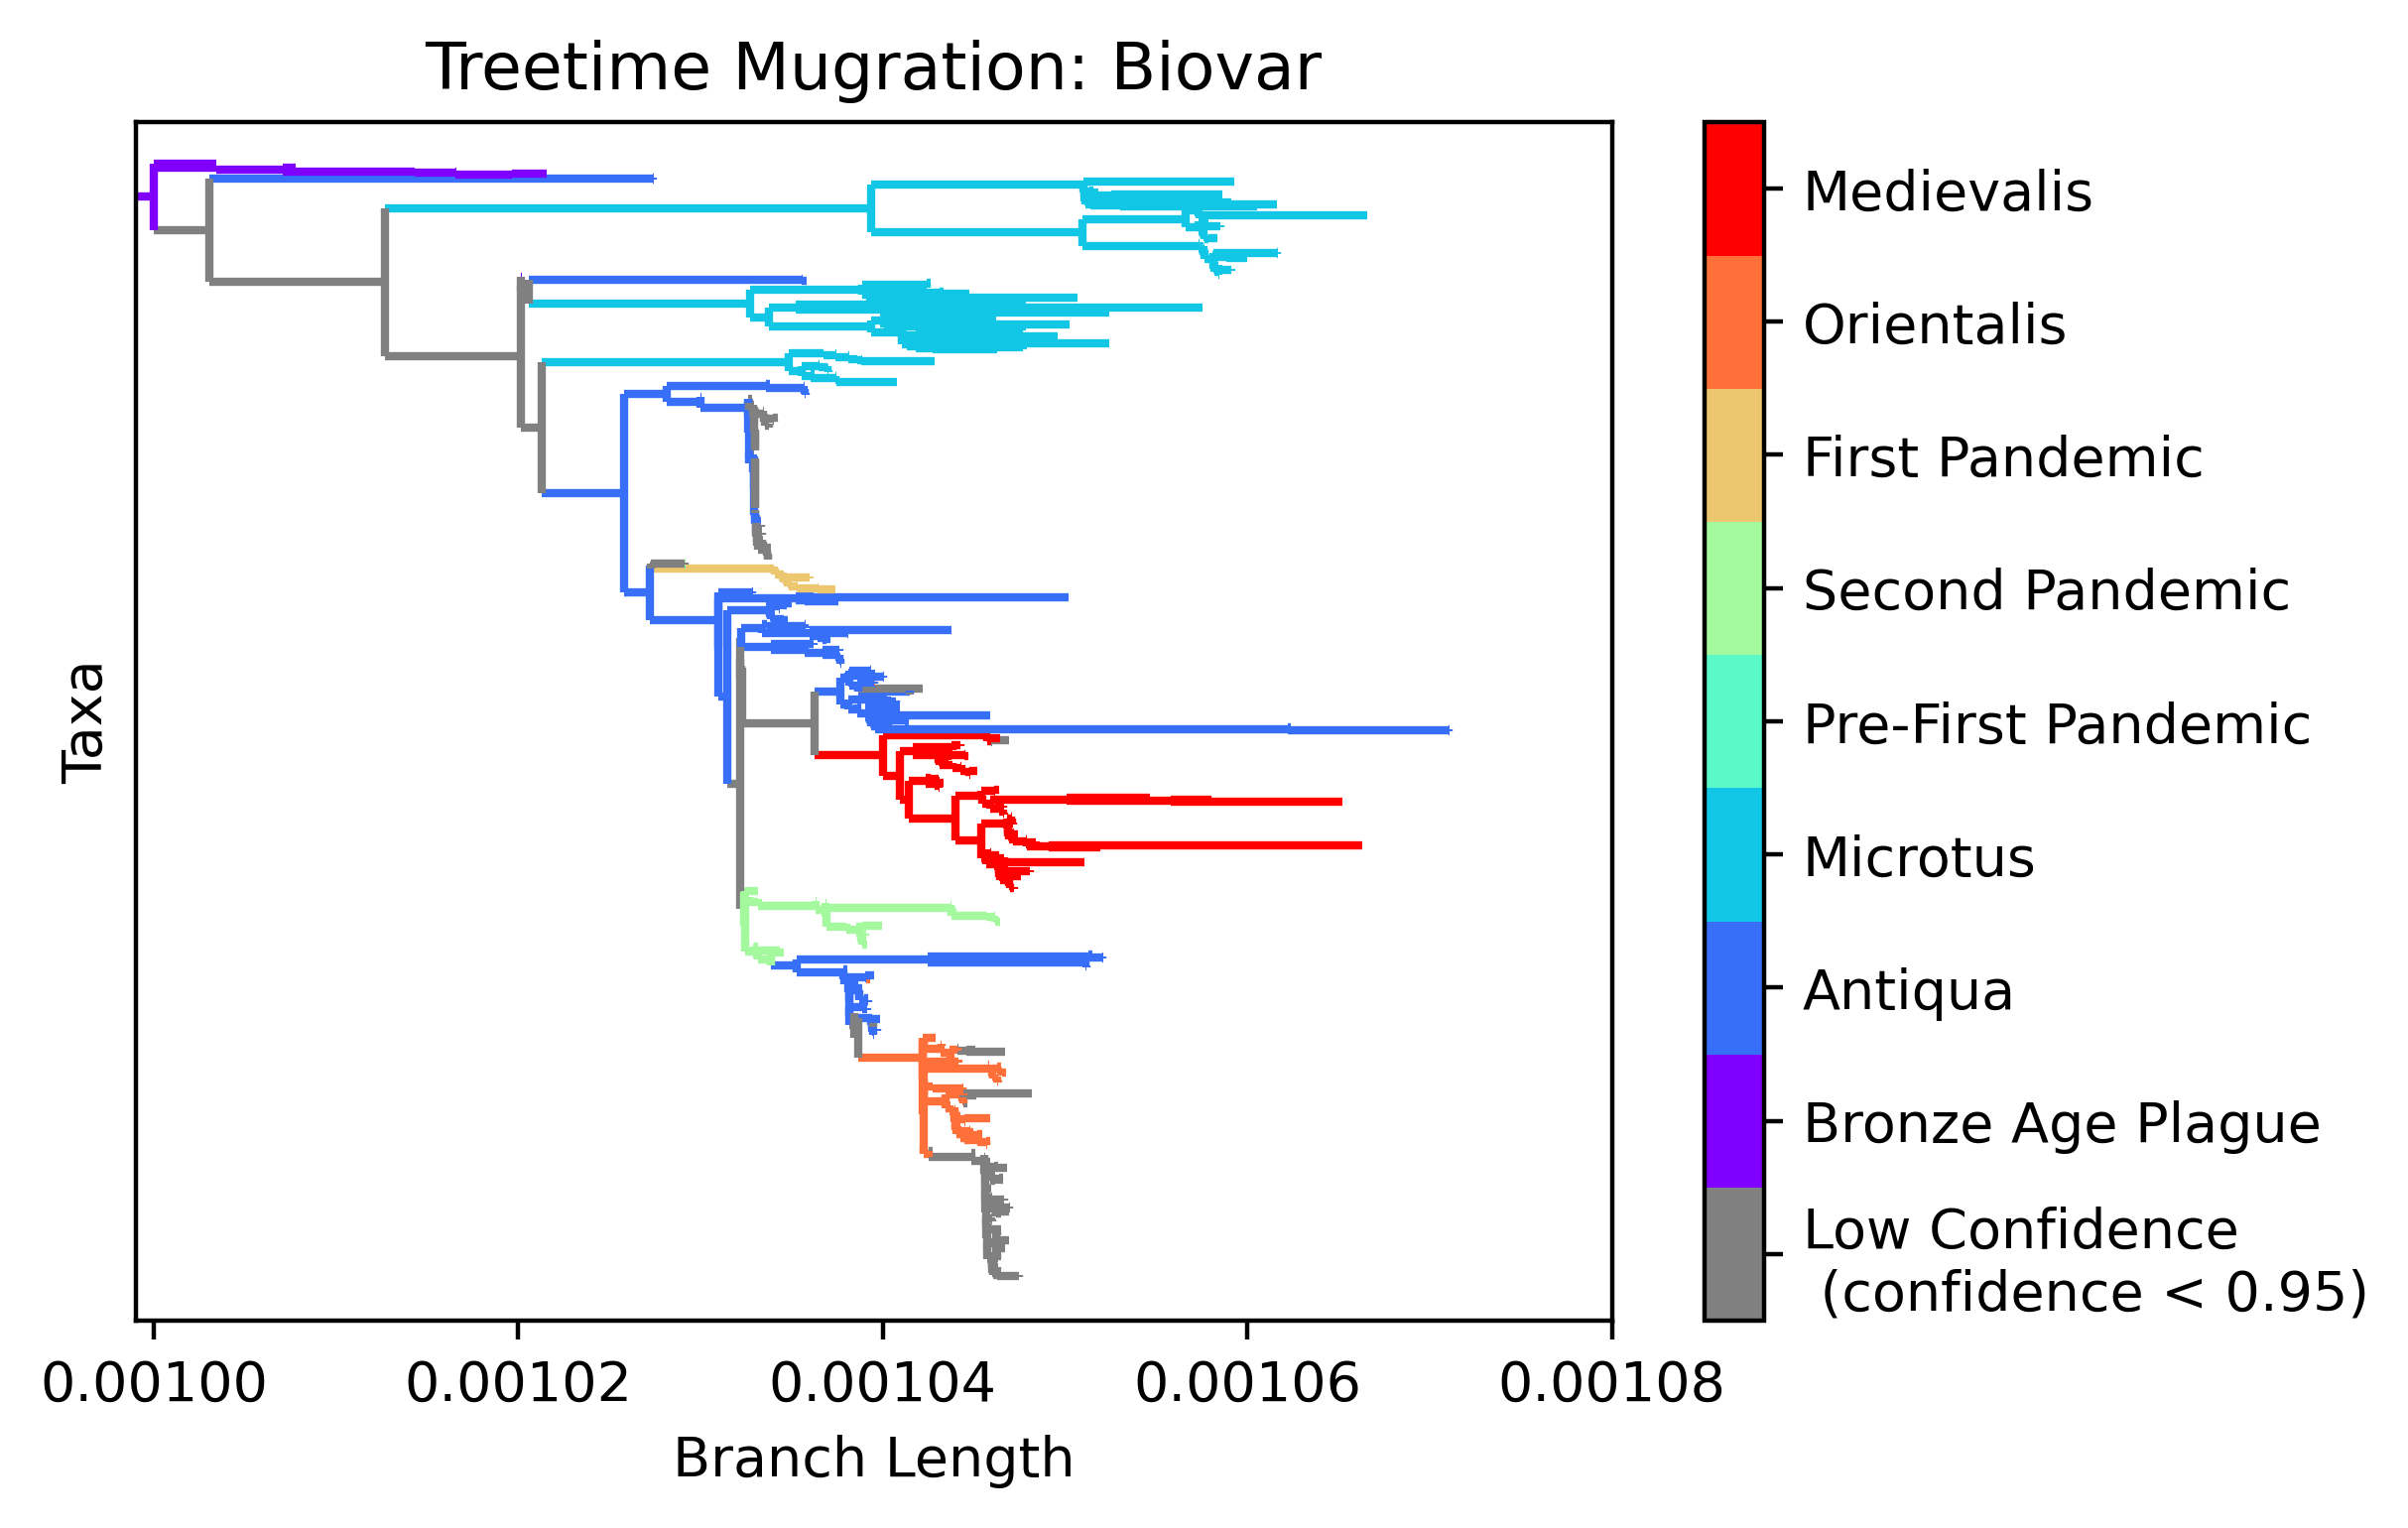

In [14]:
# Draw the tree
# ----------------------------------
# Deepest nodes last
mug_tree_div.ladderize(reverse=True)

fig = plt.figure(dpi=400)
ax = plt.subplot()

# Draw tree to the canvas
Phylo.draw(mug_tree_div, 
           axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# Root branch length set to 0.001
ax.set_xlim(0.000999,0.00108)
ax.set_ylim(-20,len(mug_tree_div.get_terminals())+20)
ax.set_yticks([])
#ax.set_xticks([])

# Create the colorbar
norm = colors.Normalize(vmin=0.5,vmax=num_attr + 0.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(1,num_attr,num_attr))

# Add conf info to Low conf label
ordered_states[0] = "Low Confidence \n (confidence < {})".format(MUG_CONF_THRESH)

cbar.ax.set_yticklabels(ordered_states) 

plt.xlabel("Branch Length")
plt.ylabel("Taxa")
plt.title("Treetime Mugration: {}".format(ATTRIBUTE))
plt.savefig("treetime_biovar_mug_tree.png", dpi=400, bbox_inches = "tight")

# Write Tree File
Phylo.write(tree_div, 
            "treetime_biovar_mug.xml",
            "phyloxml")

## Cleanup

In [15]:
os.remove(tmp_xml)